<a href="https://colab.research.google.com/github/thomaslu678/gee-test/blob/main/clean/5_visualize_sine_fit_df" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE: Requires sine_years_nX.csv and export_clean.csv (csv that contains fitted sine values for each coordinate and year, and sorted + time columns csv of export)

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timedelta
import scipy.stats as stats
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import Point
import requests

# Visualize sine_df

In [11]:
export_clean_df = pd.read_csv('/content/sample_data/export_clean.csv')

In [12]:
export_clean_df

,system:index,LST_K,distance,image_id,lat,long,mission,time,.geo,year
0,1_LT05_116034_19840730_797_0,314.209997,326.113118,LT05_116034_19840730,37.565193,126.987004,L5,1984-07-30 01:40:17,"{""type"":""MultiPoint"",""coordinates"":[]}",1984
1,1_LT05_116034_19850311_797_0,278.949702,326.113118,LT05_116034_19850311,37.565193,126.987004,L5,1985-03-11 01:41:28,"{""type"":""MultiPoint"",""coordinates"":[]}",1985
2,1_LT05_116034_19860226_797_0,271.963270,326.113118,LT05_116034_19860226,37.565193,126.987004,L5,1986-02-26 01:37:29,"{""type"":""MultiPoint"",""coordinates"":[]}",1986
3,1_LT05_116034_19860415_797_0,300.356762,326.113118,LT05_116034_19860415,37.565193,126.987004,L5,1986-04-15 01:36:29,"{""type"":""MultiPoint"",""coordinates"":[]}",1986
4,1_LT05_116034_19860517_797_0,302.188820,326.113118,LT05_116034_19860517,37.565193,126.987004,L5,1986-05-17 01:35:40,"{""type"":""MultiPoint"",""coordinates"":[]}",1986
...,...,...,...,...,...,...,...,...,...,...
2644639,3_LC08_116034_20251104_4458_0,290.868338,325.944916,LC08_116034_20251104,37.574882,127.041636,L8,2025-11-04 02:11:21,"{""type"":""MultiPoint"",""coordinates"":[]}",2025
2644640,4_LC09_116034_20251112_4458_0,290.212078,325.944916,LC09_116034_20251112,37.574882,127.041636,L9,2025-11-12 02:11:26,"{""type"":""MultiPoint"",""coordinates"":[]}",2025
2644641,4_LC09_116034_20251128_4458_0,281.089383,325.944916,LC09_116034_20251128,37.574882,127.041636,L9,2025-11-28 02:11:24,"{""type"":""MultiPoint"",""coordinates"":[]}",2025
2644642,3_LC08_116034_20251222_4458_0,274.424244,325.944916,LC08_116034_20251222,37.574882,127.041636,L8,2025-12-22 02:11:18,"{""type"":""MultiPoint"",""coordinates"":[]}",2025


In [2]:
sine_df_fit = pd.read_csv('/content/sample_data/sine_years_n10.csv')

In [3]:
sine_df_fit

,lat,long,year,A,f,phi,C
0,37.565193,126.987004,2000,35946.201296,0.000044,1.526090,-35633.718126
1,37.565193,126.987004,2001,40477.388172,0.000041,1.545114,-40169.620785
2,37.565193,126.987004,2002,20.084627,0.002772,-1.631377,298.591862
3,37.565193,126.987004,2003,20394.865090,0.000063,1.521614,-20082.256393
4,37.565193,126.987004,2004,20.242575,0.002671,-1.289138,299.666477
...,...,...,...,...,...,...,...
131074,37.574882,127.041636,2021,24.414516,0.002203,-0.467367,289.834483
131075,37.574882,127.041636,2022,37.726476,0.001623,-0.030043,275.272459
131076,37.574882,127.041636,2023,21.067235,0.002452,-0.801008,292.312055
131077,37.574882,127.041636,2024,22.473500,0.002433,-1.175560,295.178532


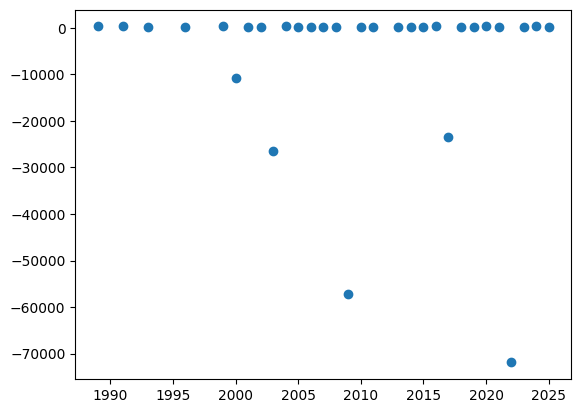

In [10]:
test_index = 100
point_1_lat_mask = sine_df_fit['lat'] == sine_df_fit.iloc[test_index]['lat']
point_1_long_mask = sine_df_fit['long'] == sine_df_fit.iloc[test_index]['long']
point_1_data = sine_df_fit[point_1_lat_mask & point_1_long_mask]
plt.scatter(point_1_data['year'], point_1_data['C'])
plt.show()

In [15]:
def graph_sine_fit_data(lat, long, year):
    lat_filter, long_filter, year_filter = lat, long, year
    bad_mask = (export_clean_df['lat'] == lat_filter) & (export_clean_df['long'] == long_filter) & (export_clean_df['year'] == year_filter)
    bad_data = export_clean_df[bad_mask]
    bad_data['time'] = pd.to_datetime(bad_data['time'])
    t0 = bad_data['time'].iloc[0]
    t_sec = (bad_data['time'] - t0).dt.total_seconds().to_numpy()

    sine_mask = (sine_df_fit['lat'] == lat_filter) & (sine_df_fit['long'] == long_filter) & (sine_df_fit['year'] == year_filter)
    sine_masked_data = sine_df_fit[sine_mask]
    # fitted parameters
    A = sine_masked_data.iloc[0]['A']
    f = sine_masked_data.iloc[0]['f']
    phi = sine_masked_data.iloc[0]['phi']
    C = sine_masked_data.iloc[0]['C']

    # create smooth time values for the fitted curve
    t_fit_sec = np.linspace(t_sec.min(), t_sec.max(), 1000)
    y_fit = A * np.sin(2 * np.pi * f * t_fit_sec + phi) + C
    t_fit = t0 + pd.to_timedelta(t_fit_sec, unit='s')

    plt.title(f"{year}: {C}")
    plt.scatter(bad_data['time'], bad_data['LST_K'])
    plt.ylim(250,
            350)
    plt.show()

    plt.title(f"{year}: {C}")
    plt.scatter(bad_data['time'], bad_data['LST_K'])
    plt.plot(t_fit, y_fit, color="red", linewidth=2, label="Sine fit")
    plt.ylim(250,
            350)
    plt.show()

    plt.title(C)
    plt.scatter(bad_data['time'], bad_data['LST_K'])
    plt.plot(t_fit, y_fit, color="red", linewidth=2, label="Sine fit")

    ax = plt.gca() # Get the current axes
    ax.relim()     # Recompute the data limits
    ax.autoscale(axis='y')

    plt.show()

/tmp/ipython-input-308597563.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_data['time'] = pd.to_datetime(bad_data['time'])


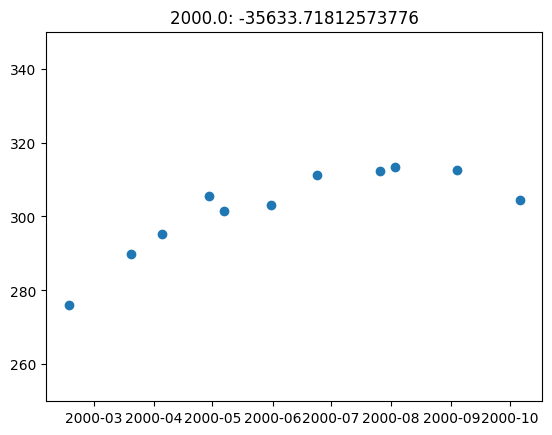

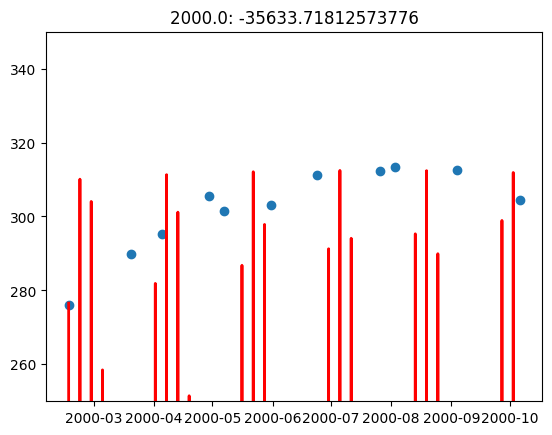

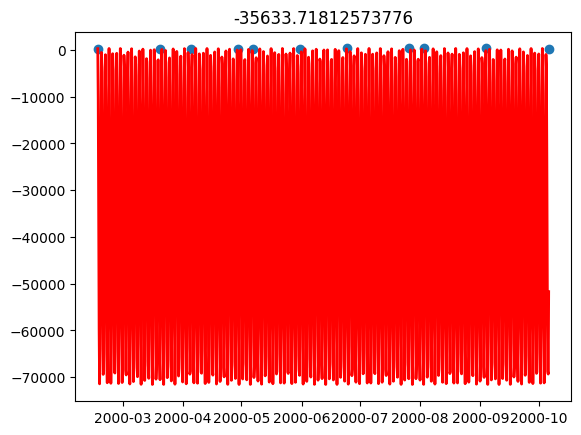

In [16]:
index = 0
lat, long, year = sine_df_fit.iloc[index]['lat'], sine_df_fit.iloc[index]['long'], sine_df_fit.iloc[index]['year']
graph_sine_fit_data(lat, long, year)